Information on the setup: https://wrds-www.wharton.upenn.edu/pages/support/programming-wrds/programming-python/python-from-your-computer/

In [3]:
import wrds
import pandas as pd
from typing import Union, Literal

Using TAQ data: https://wrds-www.wharton.upenn.edu/pages/support/manuals-and-overviews/taq/general/wrds-overview-taq/

In [4]:
def get_taq_data(
    conn: wrds.Connection, 
    ticker: str, 
    date: str, 
    data_type: Literal['trades', 'quotes'],
    time_start: str = '9:30:00', 
    time_end: str = '16:00:00',
    library: str = 'taqmsec' 
) -> Union[pd.DataFrame, None]:
    """
    Retrieves high-frequency TAQ transaction (trades) or quote data for a 
    specific ticker and date.

    Args:
        conn: The active WRDS connection object.
        ticker: The stock ticker symbol (e.g., 'AAPL').
        date: The date in 'YYYY-MM-DD' format (e.g., '2023-09-01').
        data_type: Must be 'trades' for transactions or 'quotes' for quotes.
        time_start: Start time for the data window (e.g., '9:30:00').
        time_end: End time for the data window (e.g., '16:00:00').
        library: The TAQ library to query ('taqmsec' recommended for millisecond data).

    Returns:
        A pandas DataFrame with the requested data, or None if the query fails.
    """
    
    if data_type not in ['trades', 'quotes']:
        print("Error: data_type must be 'trades' or 'quotes'.")
        return None

    # 1. Format the date for the table name (YYYYMMDD) and SQL filter (YYYY-MM-DD)
    try:
        date_sql = pd.to_datetime(date).strftime('%Y-%m-%d') 
        table_date = pd.to_datetime(date).strftime('%Y%m%d')
    except ValueError:
        print(f"Error: Invalid date format for {date}. Please use 'YYYY-MM-DD'.")
        return None
    
    # 2. Define table name prefix and columns based on data_type
    if data_type == 'trades':
        # CTM tables for Trades
        table_prefix = 'ctm'
        select_cols = """
            price,         -- Trade price
            size,          -- Trade size
            tr_scond,      -- Trade sale condition
            tr_corr        -- Trade correction indicator
        """
        trade_filters = "AND tr_corr = '00' AND price > 0 AND size > 0"
    
    elif data_type == 'quotes':
        # CQM tables for Quotes
        table_prefix = 'cqm'
        select_cols = """
            bid,           -- Best Bid Price
            bidsiz,        -- Best Bid Size
            ask,           -- Best Ask Price
            asksiz,        -- Best Ask Size
            qu_cond       -- Quote Condition
        """
        trade_filters = "" # Quotes typically don't need the same price/size filters
        
    # Construct the full table name
    table_name = f'{table_prefix}_{table_date}'
    
    # 3. Define the SQL Query
    sql_query = f"""
    SELECT 
        DATE_TRUNC('second', date) + time_m AS datetime, -- Combine for a single timestamp
        ex,              -- Exchange code
        sym_root,        -- Ticker symbol
        {select_cols}
    FROM 
        {library}.{table_name}
    WHERE 
        sym_root = '{ticker}'
        AND date = '{date_sql}'
        AND time_m >= '{time_start}'::time 
        AND time_m <= '{time_end}'::time 
        {trade_filters} 
    """
    
    print(f"Executing query for {ticker} {data_type} on {date}...")
    
    # 4. Execute the query using raw_sql()
    try:
        data = conn.raw_sql(sql_query, date_cols=['datetime'])
        
        # Set the correct index
        if not data.empty:
            data = data.set_index('datetime')
        
        print(f"Successfully retrieved {len(data)} {data_type}.")
        return data
        
    except Exception as e:
        print(f"Error retrieving {data_type} data for {ticker} on {date}: {e}")
        print("This often means the TAQ table for that date doesn't exist, or you don't have access.")
        return None

In [5]:
username = 'eghirardo' # replace with your WRDS username
ticker = 'TGT'
date = '2025-06-02'
conn = wrds.Connection(wrds_username=username) # will prompt for password first time, will store credentials in .pgpass file

OperationalError: (psycopg2.OperationalError) connection to server at "wrds-pgdata.wharton.upenn.edu" (165.123.60.118), port 9737 failed: FATAL:  PAM authentication failed for user "eghirardo"

(Background on this error at: https://sqlalche.me/e/20/e3q8)

In [8]:
trades = get_taq_data(conn, ticker, date, 'trades')
trades.sample(5)

Executing query for TGT trades on 2025-06-02...
Successfully retrieved 83831 trades.


,ex,sym_root,price,size,tr_scond,tr_corr
datetime,,,,,,
2025-06-02 19:47:45.010401+00:00,D,TGT,93.2606,100,4 B,00
2025-06-02 16:43:05.176785+00:00,N,TGT,92.87,100,F,00
2025-06-02 17:20:13.915203+00:00,T,TGT,93.06,100,<NA>,00
2025-06-02 18:50:25.197322+00:00,D,TGT,93.275,6,I,00
2025-06-02 19:21:21.211745+00:00,Z,TGT,93.38,11,F I,00


In [40]:
quotes = get_taq_data(conn, ticker, date, 'quotes')
quotes.sample(5)

Executing query for TGT quotes on 2025-06-02...
Successfully retrieved 327176 quotes.


,ex,sym_root,bid,bidsiz,ask,asksiz,qu_cond
datetime,,,,,,,
2025-06-02 15:03:55.442930+00:00,U,TGT,92.3,5,92.58,1,R
2025-06-02 17:50:09.292315+00:00,V,TGT,89.97,2,93.07,1,R
2025-06-02 17:47:28.921893+00:00,T,TGT,92.97,2,93.04,2,R
2025-06-02 14:46:14.156608+00:00,V,TGT,92.28,1,92.32,1,R
2025-06-02 19:01:19.310363+00:00,T,TGT,93.3,10,93.34,1,R


/var/folders/2n/ywnb5cc17zq6c5n2w2n7bkzw0000gn/T/ipykernel_20455/978641108.py:3: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  quotes['Spread'] = quotes.ask - quotes.bid


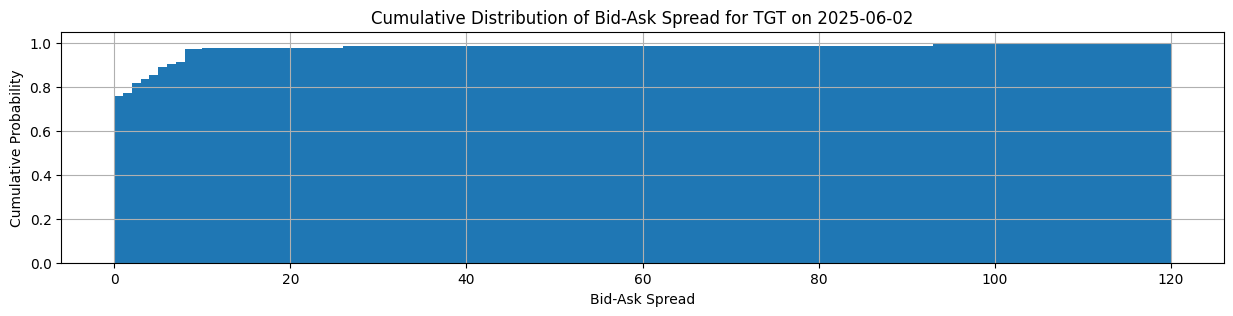

In [44]:
# example
import matplotlib.pyplot as plt
quotes['Spread'] = quotes.ask - quotes.bid

plt.figure(figsize=(15,3))
plt.hist(quotes['Spread'], bins=range(0, int(quotes['Spread'].max()) + 1), cumulative=True, density=True)
plt.grid()
plt.title(f'Cumulative Distribution of Bid-Ask Spread for {ticker} on {date}')
plt.xlabel('Bid-Ask Spread')
plt.ylabel('Cumulative Probability')
plt.show()